In [27]:
!pip install tensorflow_text

In [28]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [29]:
df = pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [30]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [31]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [32]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [33]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [34]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [35]:
df_balanced = pd.concat([df_spam,df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [36]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [37]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
3582,ham,Ard 4 lor...,0
2491,ham,Dun b sad.. It's over.. Dun thk abt it already...,0
3438,ham,Then what about further plan?,0
3872,ham,Yeah my usual guy's out of town but there're d...,0
880,spam,U have a Secret Admirer who is looking 2 make ...,1
3040,ham,"Wishing you and your family Merry ""X"" mas and ...",0
3084,ham,K..k:)how about your training process?,0
1693,ham,Weightloss! No more girl friends. Make loads o...,0
5267,ham,Anything lar then ü not going home 4 dinner?,0
5035,ham,I want to go to perumbavoor,0


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])
X_train.head(4)

3153    Hard LIVE 121 chat just 60p/min. Choose your g...
841     I luv u soo much u dont understand how specia...
5061                       I think i am disturbing her da
1109    No you'll just get a headache trying to figure...
Name: Message, dtype: object

In [39]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [40]:
def get_sentence_embeding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Darshil, are you up for a volleybal game tomorrow?"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.5132727 , -0.88845736, ..., -0.7474883 ,
        -0.75314754,  0.91964495],
       [-0.83522373, -0.50232184, -0.9494989 , ..., -0.91827416,
        -0.64916664,  0.8806614 ]], dtype=float32)>

In [41]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [42]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606916 , -0.14219397,  0.49604574, ...,  0.42165306,
        -0.5322139 ,  0.80312157],
       [-0.86023194, -0.21242912,  0.4915695 , ...,  0.39798063,
        -0.60506254,  0.8447163 ],
       [-0.7128858 , -0.15463883,  0.38401723, ...,  0.35278767,
        -0.50991315,  0.73474056],
       [-0.82533485, -0.35550627, -0.5906983 , ..., -0.01613823,
        -0.614176  ,  0.872303  ],
       [-0.75041324, -0.2681263 , -0.26689714, ...,  0.02839372,
        -0.59380966,  0.7974984 ],
       [-0.785443  , -0.29949623,  0.4102765 , ...,  0.52225506,
        -0.4957351 ,  0.81507415]], dtype=float32)>

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [44]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703803]], dtype=float32)

In [45]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872035]], dtype=float32)

In [46]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [47]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [48]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [49]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 23s 328ms/step - loss: 0.6572 - accuracy: 0.6009 - precision: 0.6000 - recall: 0.6054
Epoch 2/10
35/35 [==============================] - 12s 333ms/step - loss: 0.5181 - accuracy: 0.7857 - precision: 0.8019 - recall: 0.7589
Epoch 3/10
35/35 [==============================] - 12s 334ms/step - loss: 0.4422 - accuracy: 0.8589 - precision: 0.8384 - recall: 0.8893
Epoch 4/10
35/35 [==============================] - 12s 338ms/step - loss: 0.3908 - accuracy: 0.8741 - precision: 0.8682 - recall: 0.8821
Epoch 5/10
35/35 [==============================] - 12s 346ms/step - loss: 0.3699 - accuracy: 0.8714 - precision: 0.8586 - recall: 0.8893
Epoch 6/10
35/35 [==============================] - 12s 352ms/step - loss: 0.3318 - accuracy: 0.8821 - precision: 0.8639 - recall: 0.9071
Epoch 7/10
35/35 [==============================] - 12s 347ms/step - loss: 0.3146 - accuracy: 0.8973 - precision: 0.8843 - recall: 0.9143
Epoch 8/10
35/35 [================

In [50]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 8s 372ms/step - loss: 0.2954 - accuracy: 0.8957 - precision: 0.8895 - recall: 0.9037


[0.29544496536254883,
 0.8957219123840332,
 0.8894736766815186,
 0.903743326663971]

In [51]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 6s 336ms/step


In [52]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,

In [53]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[166,  21],
       [ 18, 169]])

Text(50.722222222222214, 0.5, 'Truth')

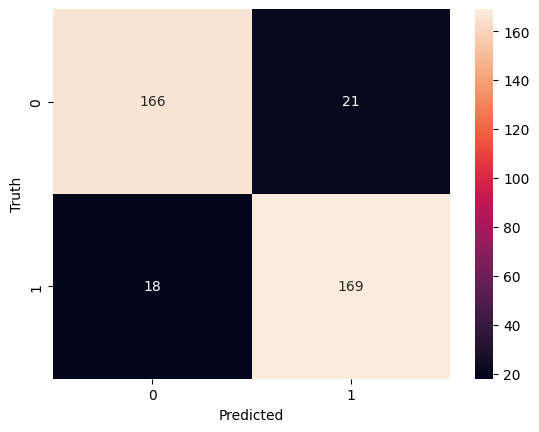

In [54]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [55]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       187
           1       0.89      0.90      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



In [56]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)


1/1 [==============================] - 2s 2s/step


array([[0.7572274 ],
       [0.8114371 ],
       [0.76203364],
       [0.14860713],
       [0.0778547 ]], dtype=float32)